In [671]:
import pandas as pd
# plot the number of unique trees vs sentence length 
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
%matplotlib inline

import math
from collections import Counter
import numpy as np
import pickle
from nltk import Tree
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

In [672]:
# load the data 
feature = pd.read_csv('final_data_cleaned.csv')

# drop the zero infection rate 
feature_c = feature[feature['INFECTION RATE'] != 0]
feature_p = feature[feature['INFECTION RATE'] == 0]

X_p = feature_p.iloc[:,4:].drop('INFECTION RATE',axis=1).to_numpy()
X = feature_c.iloc[:,4:].drop('INFECTION RATE',axis=1).to_numpy() # no population 
y = np.array(feature_c['INFECTION RATE'])


# do the train - test split 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_raw, y_test_raw = train_test_split( X, y, test_size=0.4, random_state=0)

# label y: 1: Above median, -1 below median 
mid = np.median(y_train_raw)
y_train = [1 if y_train_raw[i] >= mid else 0 for i in range(len(y_train_raw)) ]
y_test = [1 if y_test_raw[i] >= mid else 0 for i in range(len(y_test_raw)) ]
y = [1 if y[i] >= mid else 0 for i in range(len(y)) ]

> As shown above, standardizing improves the model performance. 
> Normalizing by l2 harms model performance but normalizing by l1 improves model performace, indicating the importance of feature feature selection. 

> Thus, I decide to use selected features only. However, the recall is 0.5864661654135338 after standardizing and 0.5469924812030075 after l1 norm, 0.5545112781954887 after l2 norm, 0.5582706766917294 after max

> Thus, I decide to do the hypterparameter tunning with normalized / standardize data with all the features. 

In [673]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer(norm = 'l1').fit(X_train) # norm = ‘l1’, ‘l2’,'max'
X_train_norm = transformer.transform(X_train) 
X_test_norm = transformer.transform(X_test)
X_p_norm = transformer.transform(X_p)

c_list = [0.01,0.1,0.4,0.6,0.7,0.8,0.9,1.0,5,10,20,30,40, 50]
for c in c_list:
# run logistic regression again
    clf = LogisticRegression(random_state=0,solver ='liblinear',max_iter=100, C = c)# solver = 'sag', 'saga' or 'liblinear'
    clf.fit(X_train_norm, y_train)
    y_pred = clf.predict(X_test_norm)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print('C = {}: Recall is {}, AUC = {}'.format(c, np.round(recall_score(y_test, y_pred),5),np.round(roc_auc,5)))

C = 0.01: Recall is 0.63346, AUC = 0.58708
C = 0.1: Recall is 0.66541, AUC = 0.58658
C = 0.4: Recall is 0.66353, AUC = 0.59049
C = 0.6: Recall is 0.66541, AUC = 0.5924
C = 0.7: Recall is 0.66917, AUC = 0.59621
C = 0.8: Recall is 0.66917, AUC = 0.60203
C = 0.9: Recall is 0.66165, AUC = 0.5973
C = 1.0: Recall is 0.65602, AUC = 0.59448
C = 5: Recall is 0.60902, AUC = 0.63009
C = 10: Recall is 0.57143, AUC = 0.64037
C = 20: Recall is 0.55263, AUC = 0.64356
C = 30: Recall is 0.54511, AUC = 0.64368
C = 40: Recall is 0.53947, AUC = 0.63892
C = 50: Recall is 0.53571, AUC = 0.63801


In [674]:
# best recall C =  0.8
clf = LogisticRegression(random_state=0,solver ='liblinear',max_iter=100, C = 0.8)# solver = 'sag', 'saga' or 'liblinear'
clf.fit(X_train_norm, y_train)
y_pred = clf.predict(X_test_norm)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Recall is {}, AUC = {}'.format(recall_score(y_test, y_pred),roc_auc))

Recall is 0.6691729323308271, AUC = 0.6020283266305299


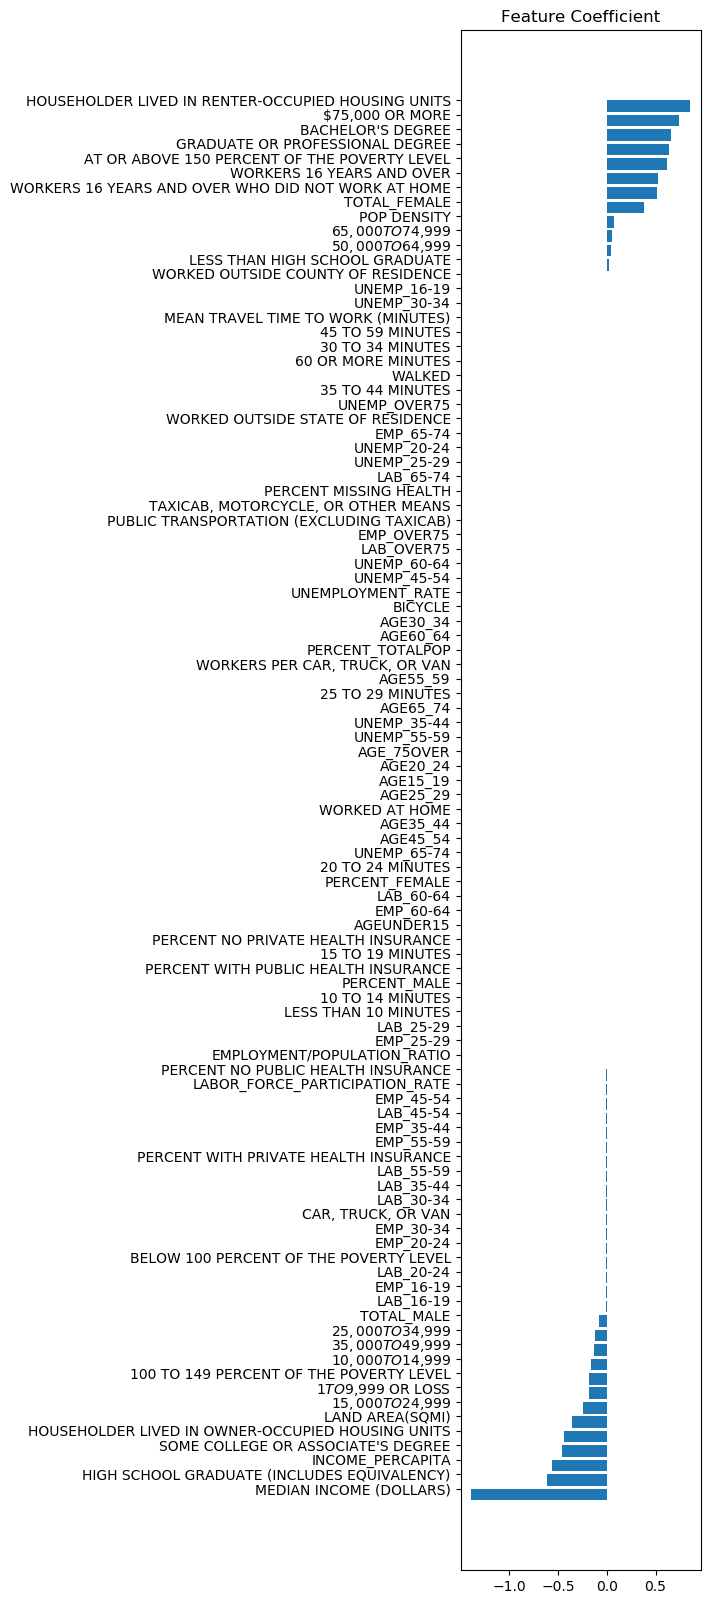

In [675]:
# get the data 
coeff = list(clf.coef_[0])
name = feature_c.iloc[:,4:].drop('INFECTION RATE',axis=1).columns
plot_data = pd.DataFrame(name,columns = ['feature'] )
plot_data['coeff'] = coeff
sort_plot_data = plot_data.sort_values(by=['coeff'],ascending = False,ignore_index = True)

# plot the data
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 20))
people = sort_plot_data['feature']
y_pos = np.arange(len(people))
performance = sort_plot_data['coeff']

ax.barh(y_pos, performance, align='edge')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('')
ax.set_title('Feature Coefficient')
plt.gcf().subplots_adjust(left = 0.6)
#plt.savefig('feature_importance_lr.png',doi = 80)
plt.show()

In [ ]:
# feature importance for logistic regression 

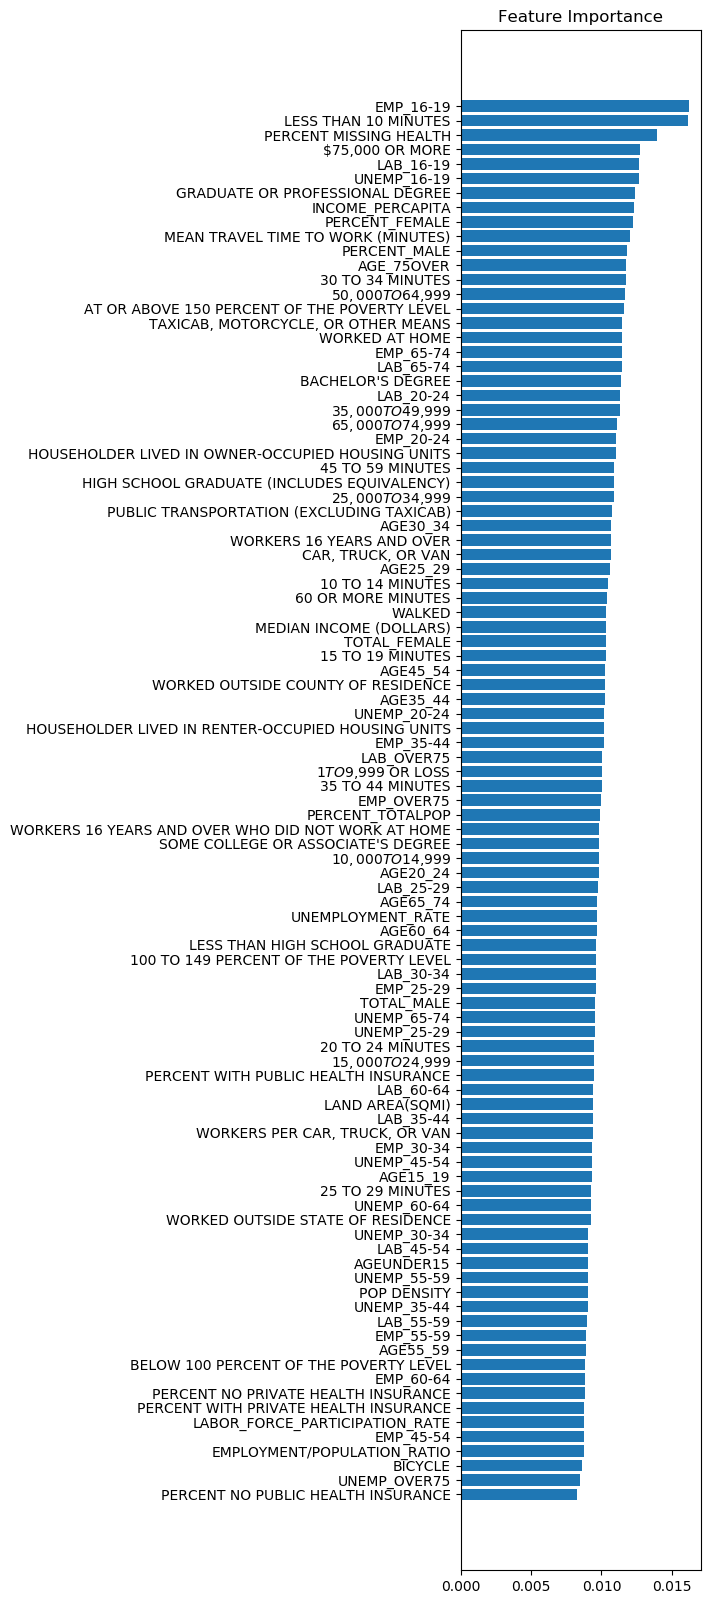

In [676]:
# classification with best model after feature selection 
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
model = ExtraTreesClassifier(n_estimators=500)
model.fit(X_train, y_train)

# get the data 
feature_imp = list(model.feature_importances_)
name = feature.iloc[:,4:].drop('INFECTION RATE',axis=1).columns
plot_imp = pd.DataFrame(name,columns = ['feature'] )
#plot_imp['coef'] = 
plot_imp['feature_imp'] = feature_imp
sort_imp = plot_imp.sort_values(by=['feature_imp'],ascending = False,ignore_index = True)

# plot
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 20))
people = sort_imp['feature']
y_pos = np.arange(len(people))
performance = sort_imp['feature_imp']

ax.barh(y_pos, performance, align='center') #color = 
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('')
ax.set_title('Feature Importance')
plt.gcf().subplots_adjust(left = 0.6)
#plt.savefig('feature_importance_lr.png',doi = 80)
plt.show()

Since using selected features doesn't improve the classification accuracy, we decide to stick to the original model.

In [680]:
# try feature selection before running logistic regression model 
X_p = feature_p.iloc[:,4:].drop('INFECTION RATE',axis=1).to_numpy()
X = feature_c.iloc[:,4:].drop('INFECTION RATE',axis=1).to_numpy() # no population 
y = np.array(feature_c['INFECTION RATE'])


# do the train - test split 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_raw, y_test_raw = train_test_split( X, y, test_size=0.4, random_state=0)

# label y: 1: Above median, -1 below median 
mid = np.median(y_train_raw)
y_train = [1 if y_train_raw[i] >= mid else 0 for i in range(len(y_train_raw)) ]
y_test = [1 if y_test_raw[i] >= mid else 0 for i in range(len(y_test_raw)) ]

In [682]:
# selected feature by feature importance 
feature_selected = sort_imp['feature'][:10]
X_new = feature_c[feature_selected].to_numpy()
y_new = np.array(feature_c['INFECTION RATE'])

# do the train - test split 
X_train_new, X_test_new, y_train_raw_new, y_test_raw_new = train_test_split(X_new, y_new, test_size=0.4, random_state=0)
mid_new = np.median(y_train_raw_new)
y_train_new = [1 if y_train_raw_new[i] >= mid_new else 0 for i in range(len(y_train_raw_new)) ]
y_test_new = [1 if y_train_raw_new[i] >= mid_new else 0 for i in range(len(y_test_raw_new)) ]

In [683]:
transformer = Normalizer(norm = 'l1').fit(X_train_new) # norm = ‘l1’, ‘l2’,'max'
X_train_new_norm = transformer.transform(X_train_new) 
X_test_new_norm = transformer.transform(X_test_new)
#X_p_new_norm = transformer.transform(X_p)

c_list = [0.01,0.03,0.05,0.06,0.07,0.08,0.09,0.1,0.4,0.6,0.7,0.8,0.9,1.0]
for c in c_list:
# run logistic regression again
    clf = LogisticRegression(random_state=0,solver ='liblinear',max_iter=100, C = c)# solver = 'sag', 'saga' or 'liblinear'
    clf.fit(X_train_new_norm, y_train_new)
    y_pred_new = clf.predict(X_test_new_norm)
    fpr, tpr, thresholds = roc_curve(y_test_new, y_pred_new)
    roc_auc = auc(fpr, tpr)
    print('C = {}: Recall is {}, AUC = {}'.format(c, np.round(recall_score(y_test_new, y_pred_new),5),np.round(roc_auc,5)))

C = 0.01: Recall is 0.27219, AUC = 0.49746
C = 0.03: Recall is 0.30966, AUC = 0.49309
C = 0.05: Recall is 0.31558, AUC = 0.48958
C = 0.06: Recall is 0.31953, AUC = 0.49063
C = 0.07: Recall is 0.32544, AUC = 0.49082
C = 0.08: Recall is 0.32742, AUC = 0.48996
C = 0.09: Recall is 0.33136, AUC = 0.49193
C = 0.1: Recall is 0.33136, AUC = 0.49193
C = 0.4: Recall is 0.35108, AUC = 0.4944
C = 0.6: Recall is 0.357, AUC = 0.49735
C = 0.7: Recall is 0.357, AUC = 0.49735
C = 0.8: Recall is 0.357, AUC = 0.49643
C = 0.9: Recall is 0.35503, AUC = 0.49544
C = 1.0: Recall is 0.357, AUC = 0.49643


In [684]:
# try SVM 
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_std, y_train)
y_pred = clf.predict((X_test_std))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Recall is {}, AUC = {}'.format(recall_score(y_test, y_pred),roc_auc))                

Recall is 0.6353383458646616, AUC = 0.6306536690563619
